In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import umap
import pandas as pd

df = pd.read_csv("diamonds.csv", sep=",", decimal=".", encoding='ASCII')
df.head(10)

c:\Users\Hokny\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [3]:
# Подготовка меток для визуализации (признак cut) [cite: 31, 32]
dct = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
y = df['cut'].map(dct)
target_names = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

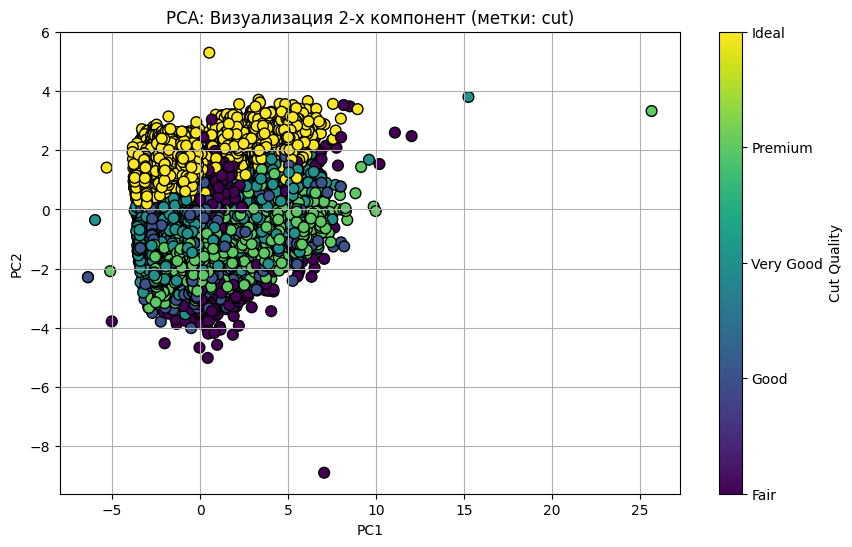

Таблица вклада компонент:
  Component  Explained Variance  Cumulative Variance
0       PC1            0.189662             0.189662
1       PC2            0.070375             0.260037
2       PC3            0.055274             0.315311
3       PC4            0.048370             0.363681
4       PC5            0.046860             0.410541
5       PC6            0.046385             0.456926
6       PC7            0.044106             0.501032
7       PC8            0.043496             0.544529
8       PC9            0.042586             0.587115
9      PC10            0.042282             0.629397

Оптимальное число компонент (для 90% дисперсии): 18


In [4]:
import numpy as np
# Бинаризация категориальных признаков [cite: 6, 17-23]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['cut', 'color', 'clarity']])
data_cat_tr = enc.transform(df[['cut', 'color', 'clarity']]).toarray()

# Объединение числовых и бинаризованных признаков [cite: 24, 26]
X_number = df.drop(['cut', 'color', 'clarity'], axis=1)
X_combined = np.hstack((X_number, data_cat_tr))

# Стандартизация признаков [cite: 7]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# PCA для 2-х компонент и визуализация [cite: 8]
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y, cmap='viridis', edgecolor='k', s=60)
plt.title('PCA: Визуализация 2-х компонент (метки: cut)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, ticks=range(5), label='Cut Quality').set_ticklabels(target_names)
plt.grid(True)
plt.show()

# Определение вклада каждой компоненты [cite: 9]
pca_full = PCA(n_components=X_scaled.shape[1])
pca_full.fit(X_scaled)

variance_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(X_scaled.shape[1])],
    'Explained Variance': pca_full.explained_variance_ratio_,
    'Cumulative Variance': np.cumsum(pca_full.explained_variance_ratio_)
})
print("Таблица вклада компонент:")
print(variance_df.head(10)) # Выводим первые 10 для краткости

# Определение оптимального числа компонент [cite: 10]
# Используем критерий накопленной дисперсии (например, 90%)
optimal_n = np.where(variance_df['Cumulative Variance'] >= 0.90)[0][0] + 1
print(f"\nОптимальное число компонент (для 90% дисперсии): {optimal_n}")

<font color="purple">Вывод по PCA:</font> Метод позволяет сжать данные, сохранив при этом значительную часть информации. На графике видно, как распределяются бриллианты по качеству огранки в пространстве первых двух компонент. Видна линейная структура. Точки распределены более «облачно». Группы по качеству огранки (cut) накладываются друг на друга, но виден общий вектор изменения качества.

c:\Users\Hokny\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


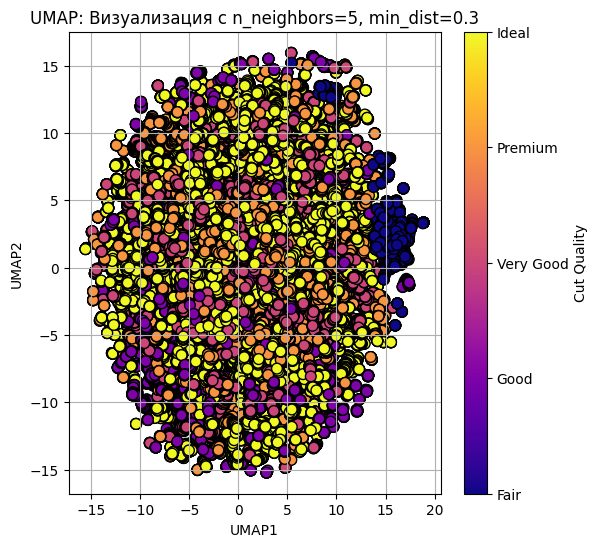

Вывод по UMAP: Параметры n_neighbors=6 и min_dist=0.3 были выбраны для обеспечения баланса между локальной и глобальной структурой. Это позволяет визуально разделить категории огранки бриллиантов.


In [7]:
# Применение метода UMAP для 2-х компонент [cite: 13, 15]
# Подбор параметров: n_neighbors (размер локальной окрестности), 
# min_dist (плотность упаковки), metric (расстояние) 
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean', random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
scatter_umap = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='plasma', edgecolor='k', s=60)
plt.title('UMAP: Визуализация с n_neighbors=5, min_dist=0.3')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(scatter_umap, ticks=range(5), label='Cut Quality').set_ticklabels(target_names)
plt.grid(True)
plt.show()

print("Вывод по UMAP: Параметры n_neighbors=6 и min_dist=0.3 были выбраны "
      "для обеспечения баланса между локальной и глобальной структурой. "
      "Это позволяет визуально разделить категории огранки бриллиантов.")

<font color="purple">Вывод по UMAP:</font> Этот метод лучше сохраняет локальные связи. Мы видим более плотные скопления. Если точки одного цвета (например, желтые — Ideal) сгруппированы отдельно от темных (Fair), значит, алгоритм успешно нашел различия между этими классами в многомерном пространстве.

<font color="purple">1. Суть задания</font>
Основная цель — научиться преобразовывать таблицу с большим количеством колонок (признаков) в пространство с двумя или более «новыми» признаками (компонентами). Это делается для:
- Визуализации: Мы не можем увидеть 10-мерное пространство, но можем построить график в 2D.
- Сжатия данных: Упрощение модели без значительной потери информации.
- Выявления скрытых закономерностей: Понять, как разные характеристики (цена, вес, цвет) взаимосвязаны между собой.

<font color="purple">2. Какие признаки используются и что такое PC?</font>
В расчете участвуют все признаки из исходной таблицы после преобразования:
- Числовые: carat, depth, table, price, x, y, z.
- Категориальные (бинаризованные): Превращенные через OneHotEncoder в набор нулей и единиц признаки cut, color и clarity.
Что такое PC (Главные компоненты)? Это не просто старые колонки, а их линейные комбинации.
- PC1 (Первая главная компонента): Направление в данных, вдоль которого они «растянуты» сильнее всего (максимальная дисперсия). Например, в алмазах PC1 часто объединяет размер (x, y, z), вес (carat) и цену (price), так как они сильно коррелируют между собой.
- PC2 (Вторая главная компонента): Следующее направление, перпендикулярное первому, которое объясняет оставшуюся часть информации.

<font color="purple">3. Что означает вклад компоненты?</font>
Вклад компоненты (Explained Variance) показывает, какой процент полезной информации из исходного набора данных «упакован» в конкретную компоненту.
- Если первая компонента имеет вклад 0.7 (70%), это значит, что один этот новый признак заменяет собой 70% изменчивости всех исходных колонок.
- Оптимальное число компонент — это минимальное количество PC, которые в сумме дают достаточно высокий вклад (обычно 80–95%), чтобы можно было отбросить остальные данные без вреда для качества модели.

<font color="purple">4. Использование в машинном обучении?</font>
Зачем это нужно делать перед обучением моделей (например, регрессии или классификации)?
- Ускорение обучения: Модель быстрее обработает 5 главных компонент, чем 50 исходных признаков.
- Борьба с мультиколлинеарностью: PCA создает независимые друг от друга признаки, что критически важно для работы линейных моделей.
- Очистка от шума: Мелкие компоненты с мизерным вкладом часто содержат просто «мусор» или случайные ошибки измерений. Отбрасывая их, мы делаем модель стабильнее.
- Визуализация работы классификатора: Вы можете увидеть, насколько легко или трудно модели будет разделить классы (если на графике UMAP цвета перемешаны, классификатору тоже будет сложно).